<a href="https://colab.research.google.com/github/akshatshah91/Game-AI/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import randint
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')
from collections import deque
import sys
import numpy as np
import copy

In [10]:
EPS_START = 1  # e-greedy threshold start value
EPS_END = 0.001  # e-greedy threshold end value
EPS_DECAY = 0.995  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
HIDDEN_LAYER = 32  # NN hidden layer size

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
Tensor = FloatTensor

In [11]:
class DQN(nn.Module):
  def __init__(self, inputSize, outputSize):
    nn.Module.__init__(self)
    self.linear1 = nn.Linear(inputSize, HIDDEN_LAYER)
    self.linear2 = nn.Linear(HIDDEN_LAYER, outputSize)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    return self.linear2(x)

In [17]:
class DQNAgent():
    def __init__(self, inputSize, outputSize, batchSize, learningRate):
        self.model = DQN(inputSize, outputSize)
        self.targetModel = copy.deepcopy(self.model)
        self.memory = deque(maxlen=2000)
        self.batchSize = batchSize
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.epsilon = 1
        self.optimizer1 = torch.optim.Adam(self.model.parameters(), lr=learningRate)
        self.optimizer2 = torch.optim.Adam(self.targetModel.parameters(), lr=learningRate)

    def store(self, transition):
      self.memory.append(transition)

    def act(self, state):
      if random.random() < self.epsilon:
        return random.randrange(self.outputSize)
      else:
        return np.argmax(self.model.forward(state).detach().numpy())

    def computeLoss(self, minibatch):
      state, action, reward, nextState, gameOver = zip(*minibatch)
      state = torch.FloatTensor(state)
      action = torch.LongTensor(action)
      reward = torch.FloatTensor(reward)
      nextState = torch.FloatTensor(nextState)
      gameOver = torch.FloatTensor(gameOver)
      action = action.view(action.size(0), 1)
      gameOver = gameOver.view(gameOver.size(0), 1)
      qVal1 = self.model.forward(state).gather(1,action)
      qVal2 = self.targetModel.forward(state).gather(1,action)
      nextQVal1 = self.model.forward(nextState)
      nextQVal2 = self.targetModel.forward(nextState)
      nextQVal = torch.min(torch.max(self.model.forward(nextState), 1)[0],torch.max(self.targetModel.forward(nextState), 1)[0])
      nextQVal = nextQVal.view(nextQVal.size(0), 1)
      expectedQVal = reward + (1 - gameOver) * GAMMA * nextQVal
      loss1 = F.mse_loss(qVal1, expectedQVal.detach())
      loss2 = F.mse_loss(qVal2, expectedQVal.detach())
      return loss1,loss2

    def update(self):
      if len(self.memory) < self.batchSize:
        return
      minibatch = random.sample(self.memory, k=self.batchSize)
      loss1,loss2 = self.computeLoss(minibatch)
      self.optimizer1.zero_grad()
      self.optimizer2.zero_grad()
      loss1.backward()
      loss2.backward()
      self.optimizer1.step()
      self.optimizer2.step()
      if self.epsilon > EPS_END:
        self.epsilon *= EPS_DECAY

In [21]:
def train(env, stateSize, actionSize, fig, batchSize, learningRate):
  print("------HYPERPARAMETERS------")
  print("Batch Size =", batchSize)
  print("Learning Rate =", learningRate)
  print("---------------------------")
  agent = DQNAgent(stateSize, actionSize, batchSize, learningRate)
  rewards = []
  avg = []
  ep = []
  avgInterval = int(EPISODES/50)
  for x in range(1, EPISODES+1):
    state = env.reset()
    gameOver = False
    total = 0
    while not gameOver:
      action = agent.act(torch.FloatTensor(state))
      nextState,reward,gameOver,_ = env.step(action)
      agent.store((state, action, reward, nextState, gameOver))
      state = nextState
      total += reward
      agent.update()
    rewards.append(total)
    if x % avgInterval == 0:
      avg.append(sum(rewards[-avgInterval:])/avgInterval)
      ep.append(x)
      print("Episode [", x, "/", EPISODES, "] Score [", avg[-1], "]", sep='')
  plt.figure(fig)
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(rewards)
  plt.plot(ep, avg)
  plt.show()
  label = "Batchsize=" + str(batchSize) + " LR=" + str(learningRate)
  return (ep, avg, label)

------HYPERPARAMETERS------
Batch Size = 16
Learning Rate = 0.001
---------------------------
Episode [10/500] Score [19.0]
Episode [20/500] Score [12.6]
Episode [30/500] Score [10.9]
Episode [40/500] Score [10.0]
Episode [50/500] Score [14.3]
Episode [60/500] Score [16.2]
Episode [70/500] Score [14.7]
Episode [80/500] Score [18.2]
Episode [90/500] Score [75.6]
Episode [100/500] Score [59.3]
Episode [110/500] Score [63.3]
Episode [120/500] Score [47.8]
Episode [130/500] Score [100.6]
Episode [140/500] Score [343.7]
Episode [150/500] Score [201.3]
Episode [160/500] Score [212.9]
Episode [170/500] Score [162.7]
Episode [180/500] Score [218.0]
Episode [190/500] Score [273.9]
Episode [200/500] Score [261.5]
Episode [210/500] Score [262.2]
Episode [220/500] Score [235.2]
Episode [230/500] Score [26.8]
Episode [240/500] Score [57.7]
Episode [250/500] Score [163.1]
Episode [260/500] Score [345.7]
Episode [270/500] Score [183.1]
Episode [280/500] Score [102.1]
Episode [290/500] Score [290.6]
E

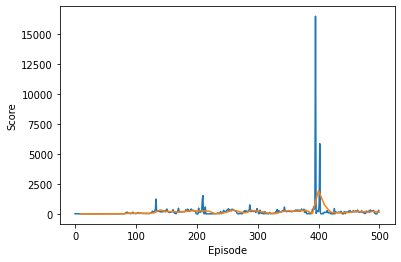

------HYPERPARAMETERS------
Batch Size = 16
Learning Rate = 0.005
---------------------------
Episode [10/500] Score [17.7]
Episode [20/500] Score [44.7]
Episode [30/500] Score [47.2]
Episode [40/500] Score [47.3]
Episode [50/500] Score [70.1]
Episode [60/500] Score [133.3]
Episode [70/500] Score [214.7]
Episode [80/500] Score [139.0]
Episode [90/500] Score [196.8]
Episode [100/500] Score [186.5]
Episode [110/500] Score [128.9]
Episode [120/500] Score [109.3]
Episode [130/500] Score [171.1]
Episode [140/500] Score [141.4]
Episode [150/500] Score [104.0]
Episode [160/500] Score [115.5]
Episode [170/500] Score [359.5]
Episode [180/500] Score [76.3]
Episode [190/500] Score [152.9]
Episode [200/500] Score [132.5]
Episode [210/500] Score [85.6]
Episode [220/500] Score [166.6]
Episode [230/500] Score [135.3]
Episode [240/500] Score [148.3]
Episode [250/500] Score [46.8]
Episode [260/500] Score [254.0]
Episode [270/500] Score [147.5]
Episode [280/500] Score [249.9]
Episode [290/500] Score [23

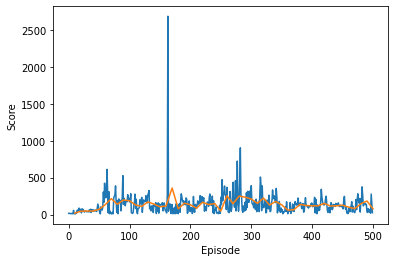

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.001
---------------------------
Episode [10/500] Score [22.0]
Episode [20/500] Score [10.7]
Episode [30/500] Score [12.6]
Episode [40/500] Score [14.5]
Episode [50/500] Score [11.8]
Episode [60/500] Score [11.7]
Episode [70/500] Score [30.6]
Episode [80/500] Score [32.3]
Episode [90/500] Score [56.8]
Episode [100/500] Score [73.4]
Episode [110/500] Score [100.6]
Episode [120/500] Score [97.4]
Episode [130/500] Score [87.0]
Episode [140/500] Score [79.6]
Episode [150/500] Score [125.8]
Episode [160/500] Score [154.6]
Episode [170/500] Score [192.6]
Episode [180/500] Score [147.9]
Episode [190/500] Score [123.1]
Episode [200/500] Score [131.5]
Episode [210/500] Score [126.1]
Episode [220/500] Score [432.0]
Episode [230/500] Score [284.7]
Episode [240/500] Score [241.8]
Episode [250/500] Score [185.9]
Episode [260/500] Score [70.6]
Episode [270/500] Score [283.6]
Episode [280/500] Score [341.7]
Episode [290/500] Score [253.5]
E

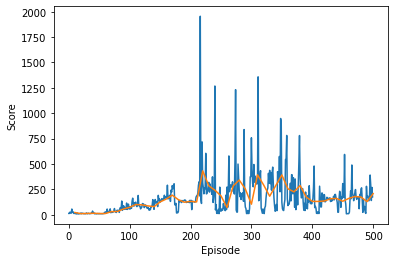

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.005
---------------------------
Episode [10/500] Score [21.3]
Episode [20/500] Score [17.6]
Episode [30/500] Score [70.4]
Episode [40/500] Score [174.4]
Episode [50/500] Score [141.0]
Episode [60/500] Score [120.9]
Episode [70/500] Score [162.0]
Episode [80/500] Score [79.8]
Episode [90/500] Score [71.6]
Episode [100/500] Score [234.9]
Episode [110/500] Score [170.7]
Episode [120/500] Score [184.0]
Episode [130/500] Score [95.2]
Episode [140/500] Score [158.1]
Episode [150/500] Score [56.0]
Episode [160/500] Score [208.3]
Episode [170/500] Score [212.6]
Episode [180/500] Score [265.6]
Episode [190/500] Score [237.5]
Episode [200/500] Score [150.6]
Episode [210/500] Score [125.7]
Episode [220/500] Score [185.9]
Episode [230/500] Score [141.0]
Episode [240/500] Score [129.5]
Episode [250/500] Score [113.6]
Episode [260/500] Score [127.3]
Episode [270/500] Score [175.2]
Episode [280/500] Score [168.1]
Episode [290/500] Score [2

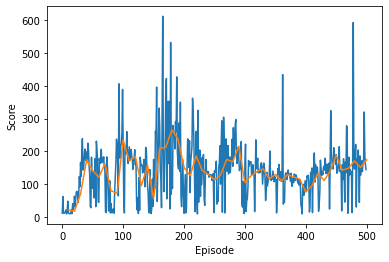

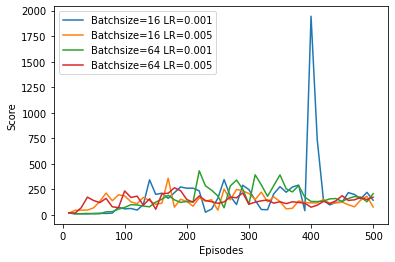

In [23]:
env = gym.make('CartPole-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 500

avgRewards = []
batchSizes = [16, 64]
learningRates = [0.001, 0.005]
x = 1
for b in batchSizes:
  for l in learningRates:
    avgRewards.append(train(env, stateSize, actionSize, x, b, l))
    x += 1

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()

------HYPERPARAMETERS------
Batch Size = 16
Learning Rate = 0.001
---------------------------
Episode [10/500] Score [482.5]
Episode [20/500] Score [332.5]
Episode [30/500] Score [382.5]
Episode [40/500] Score [330.0]
Episode [50/500] Score [237.5]
Episode [60/500] Score [185.0]
Episode [70/500] Score [232.5]
Episode [80/500] Score [395.0]
Episode [90/500] Score [127.5]
Episode [100/500] Score [192.5]
Episode [110/500] Score [285.0]
Episode [120/500] Score [717.5]
Episode [130/500] Score [535.0]
Episode [140/500] Score [262.5]
Episode [150/500] Score [262.5]
Episode [160/500] Score [275.0]
Episode [170/500] Score [275.0]
Episode [180/500] Score [245.0]
Episode [190/500] Score [275.0]
Episode [200/500] Score [240.0]
Episode [210/500] Score [257.5]
Episode [220/500] Score [235.0]
Episode [230/500] Score [257.5]
Episode [240/500] Score [280.0]
Episode [250/500] Score [237.5]
Episode [260/500] Score [265.0]
Episode [270/500] Score [252.5]
Episode [280/500] Score [275.0]
Episode [290/500] S

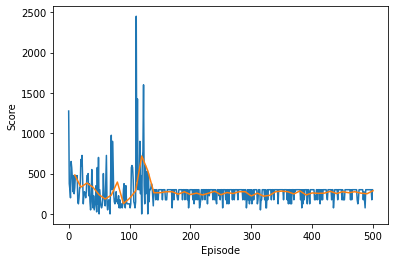

------HYPERPARAMETERS------
Batch Size = 16
Learning Rate = 0.005
---------------------------
Episode [10/500] Score [360.0]
Episode [20/500] Score [262.5]
Episode [30/500] Score [287.5]
Episode [40/500] Score [275.0]
Episode [50/500] Score [270.0]
Episode [60/500] Score [270.0]
Episode [70/500] Score [225.0]
Episode [80/500] Score [242.5]
Episode [90/500] Score [270.0]
Episode [100/500] Score [252.5]
Episode [110/500] Score [275.0]
Episode [120/500] Score [392.5]
Episode [130/500] Score [257.5]
Episode [140/500] Score [235.0]
Episode [150/500] Score [240.0]
Episode [160/500] Score [240.0]
Episode [170/500] Score [257.5]
Episode [180/500] Score [270.0]
Episode [190/500] Score [277.5]
Episode [200/500] Score [252.5]
Episode [210/500] Score [262.5]
Episode [220/500] Score [257.5]
Episode [230/500] Score [230.0]
Episode [240/500] Score [295.0]
Episode [250/500] Score [257.5]
Episode [260/500] Score [215.0]
Episode [270/500] Score [255.0]
Episode [280/500] Score [237.5]
Episode [290/500] S

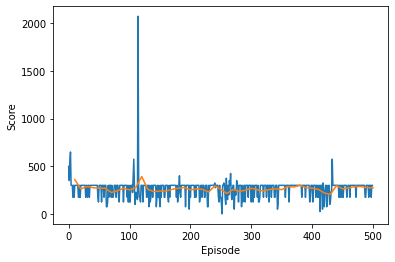

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.001
---------------------------
Episode [10/500] Score [560.0]
Episode [20/500] Score [585.0]
Episode [30/500] Score [585.0]
Episode [40/500] Score [427.5]
Episode [50/500] Score [420.0]
Episode [60/500] Score [425.0]
Episode [70/500] Score [172.5]
Episode [80/500] Score [250.0]
Episode [90/500] Score [270.0]
Episode [100/500] Score [252.5]
Episode [110/500] Score [262.5]
Episode [120/500] Score [287.5]
Episode [130/500] Score [237.5]
Episode [140/500] Score [290.0]
Episode [150/500] Score [287.5]
Episode [160/500] Score [245.0]
Episode [170/500] Score [245.0]
Episode [180/500] Score [265.0]
Episode [190/500] Score [257.5]
Episode [200/500] Score [277.5]
Episode [210/500] Score [270.0]
Episode [220/500] Score [227.5]
Episode [230/500] Score [227.5]
Episode [240/500] Score [287.5]
Episode [250/500] Score [270.0]
Episode [260/500] Score [240.0]
Episode [270/500] Score [257.5]
Episode [280/500] Score [245.0]
Episode [290/500] S

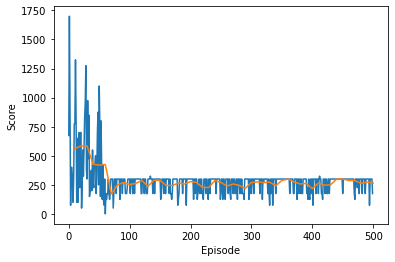

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.005
---------------------------
Episode [10/500] Score [357.5]
Episode [20/500] Score [212.5]
Episode [30/500] Score [182.5]
Episode [40/500] Score [222.5]
Episode [50/500] Score [257.5]
Episode [60/500] Score [172.5]
Episode [70/500] Score [175.0]
Episode [80/500] Score [182.5]
Episode [90/500] Score [282.5]
Episode [100/500] Score [287.5]
Episode [110/500] Score [247.5]
Episode [120/500] Score [252.5]
Episode [130/500] Score [245.0]
Episode [140/500] Score [232.5]
Episode [150/500] Score [287.5]
Episode [160/500] Score [230.0]
Episode [170/500] Score [252.5]
Episode [180/500] Score [245.0]
Episode [190/500] Score [287.5]
Episode [200/500] Score [280.0]
Episode [210/500] Score [205.0]
Episode [220/500] Score [260.0]
Episode [230/500] Score [250.0]
Episode [240/500] Score [277.5]
Episode [250/500] Score [282.5]
Episode [260/500] Score [262.5]
Episode [270/500] Score [300.0]
Episode [280/500] Score [275.0]
Episode [290/500] S

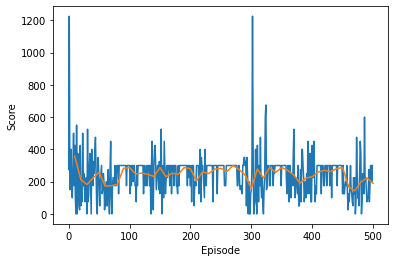

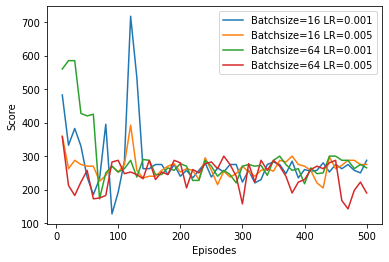

In [25]:
env = gym.make('AirRaid-ram-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 500

avgRewards = []
batchSizes = [16, 64]
learningRates = [0.001, 0.005]
x = 1
for b in batchSizes:
  for l in learningRates:
    avgRewards.append(train(env, stateSize, actionSize, x, b, l))
    x += 1

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()

The first thing I notice is that all four tests converge at certain ranges. Re-running the algorithms has confirmed this. Comparing just these hyperparameters, I notice that there is not much difference between having a batchsize of 16 or 64. However, the tests with larger batch sizes converge much quicker. This makes sense because a larger batchsize means there are more updates happening. Looking at the learning rate, it seems that even with a slight increase from 0.001 to 0.005 you can visually see how much variance the higher learning rate has. I wanted to continue doing tests experimenting with the amount of hidden layers and their sizes, however, the tests were taking too long to compute already and I ran out time. In the future, I see that 0.001 is a better learning rate and a larger batch size is better.

I chose these two environments specifically so that I could compare my results with my previous ones from HW2 where we used a combination of genetic algorithms and neural networks. Even with my double DQN, I can see that my average score is not as high as the ones from HW2. I did manage to get a higher high score than HW2, however, but that is not as important since my algorithm could not replicate the success. What I have noticed is that GA with NN seems to outperform DQNs when it comes to simpler tasks. They are much faster and seem to do fairly well. I suspect that with more training and configurations of hyperparameters the DQNs could do better, but it is not worthwhile for simple tasks. However, with more complicated tasks, I suspect DQNs will outperform GA with NNs because everything has to be more finely tuned and you can't get that with the randomness of GA with NNs.